<a href="https://colab.research.google.com/github/rahiakela/kaggle-competition-projects/blob/master/us-patent-phrase-competition/01_us_patent_phrase_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##US Patent Phrase to Phrase maching - EDA

In this dataset, you are presented pairs of phrases (an anchor and a target phrase) and asked to rate how similar they are on a scale from 0 (not at all similar) to 1 (identical in meaning). This challenge differs from a standard semantic similarity task in that similarity has been scored here within a patent's context, specifically its CPC classification (version 2021.05), which indicates the subject to which the patent relates. For example, while the phrases "bird" and "Cape Cod" may have low semantic similarity in normal language, the likeness of their meaning is much closer if considered in the context of "house".

This is a code competition, in which you will submit code that will be run against an unseen test set. The unseen test set contains approximately 12k pairs of phrases. A small public test set has been provided for testing purposes, but is not used in scoring.

Information on the meaning of CPC codes may be found on the USPTO website. The CPC version 2021.05 can be found on the CPC archive website.

**Score meanings**

The scores are in the 0-1 range with increments of 0.25 with the following meanings:

* **1.0 - Very close match**. This is typically an exact match except possibly for differences in conjugation, quantity (e.g. singular vs. plural), and addition or removal of stopwords (e.g. “the”, “and”, “or”).
* **0.75 - Close synonym**, e.g. “mobile phone” vs. “cellphone”. This also includes abbreviations, e.g. "TCP" -> "transmission control protocol".
* **0.5 - Synonyms** which don’t have the same meaning (same function, same properties). This includes broad-narrow (hyponym) and narrow-broad (hypernym) matches.
* **0.25 - Somewhat related**, e.g. the two phrases are in the same high level domain but are not synonyms. This also includes antonyms.
* **0.0 - Unrelated**.

**Columns**

* **id** - a unique identifier for a pair of phrases
* **anchor** - the first phrase
* **target** - the second phrase
* **context** - the CPC classification (version 2021.05), which indicates the subject within which the similarity is to be scored
* **score** - the similarity. This is sourced from a combination of one or more manual expert ratings.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud,STOPWORDS
from termcolor import colored

colors = ["#A2A21C", "#CBCB1A", "#E1E10B", "#F6F605", "#838305"]

Let's load dataset from Kaggle.

In [ ]:
from google.colab import files
files.upload() # upload kaggle.json file

In [ ]:
%%shell

mkdir -p ~/.kaggle
mv kaggle.json ~/.kaggle/
ls ~/.kaggle
chmod 600 /root/.kaggle/kaggle.json

# download dataset from kaggle> URL: https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching
kaggle competitions download -c us-patent-phrase-to-phrase-matching
unzip -qq us-patent-phrase-to-phrase-matching.zip

## Loading dataset 

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

print(train.shape, test.shape)

(36473, 5) (36, 4)


In [5]:
train.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36473 entries, 0 to 36472
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       36473 non-null  object 
 1   anchor   36473 non-null  object 
 2   target   36473 non-null  object 
 3   context  36473 non-null  object 
 4   score    36473 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.4+ MB


In [8]:
#check null value
train.isnull().sum()

id         0
anchor     0
target     0
context    0
score      0
dtype: int64

No null values present in training data

## Dataset Exploration

###Scores Distribution

In [9]:
score_counts = train["score"].astype(str).value_counts()

fig = go.Figure([go.Bar(x=score_counts.index,
                        y=score_counts.values,
                        text=score_counts.values,
                        marker_color=colors[0])])

fig.update_layout(barmode="stack", 
                  title_text="Scores Distribution", 
                  xaxis_title="Scores",
                  yaxis_title="Counts")
fig.show()

So score = 1.0 (very close matches) are very less and score = 0.5 (synonyms which don't have same meanings) are above 12k.

###Anchors count

In [11]:
anchor_counts = train["anchor"].value_counts()[:15][::-1]

fig = go.Figure([go.Bar(x=anchor_counts.values,
                        y=anchor_counts.keys(),
                        text=anchor_counts.values,
                        marker_color=colors[1],
                        orientation="h")])

fig.update_layout(barmode="stack", 
                  title_text="Top 15 anchors count", 
                  xaxis_title="Counts",
                  yaxis_title="Anchor",
                  height=600)
fig.update_xaxes(showticklabels=False)
fig.show()

###Word length distribution

Let's calculate word length and character length of target.

In [12]:
train["target_wordlen"] = train["target"].apply(lambda x: len(x.split()))
train["target_charlen"] = train["target"].apply(lambda x: len(x))

train.head()

,id,anchor,target,context,score,target_wordlen,target_charlen
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,3,22
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,3,14
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,2,15
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,2,19
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,2,13


In [15]:
fig = px.histogram(train, 
                   x="target_wordlen",
                   color_discrete_sequence=[colors[2]],
                   title="Target word length distribution")
fig.show()

In [16]:
max_targets = train[train["target_wordlen"] >= 10]["target"].values
anchors = train[train["target_wordlen"] >= 10]["anchor"].values

for anchor, target in zip(anchors, max_targets):
  print(f"{anchor} : {colored(target, 'yellow')}")

based propellant : a substance used as a reagent in a rocket engine
biocytin : 2s 6 5 3as4s6ar 2 oxo 133a466a hexahydrothieno34 dimidazol 4 ylpentanoylamino 2 azaniumylhexanoate
glycitin : 3 4 hydroxyphenyl 6 methoxy 7 2s3r4s5s6r 345 trihydroxy 6 hydroxymethyloxan 2 yloxychromen 4 one
mayenite : heating calcium oxide and aluminium oxide together at high temperatures
paraboloid : a quadric surface that has exactly one axis of symmetry
photocleavable linker : n 9 fluorenylmethyloxycarbonyl 3 amino 3 45 dimethoxy 2 nitrophenylpropionic acid
rizatriptan : 1h indole 3 ethanamine nn dimethyl 5 1h 124 triazol 1 ylmethyl
rizatriptan : 2 5 1h 124 triazol 1 ylmethyl 1h indol 3 yl nn dimethylethanamine
rizatriptan : nn dimethyl 2 5 124 triazol 1 ylmethyl 1h indol 3 ylethanamine


We see that most of the highest word length are chemical formulas.

###Character length distribution

In [17]:
fig = px.histogram(train, 
                   x="target_charlen",
                   color_discrete_sequence=[colors[2]],
                   title="Target character length distribution")
fig.show()

###Context Distribution

In [18]:
context_counts = train["context"].value_counts()

fig = go.Figure([go.Bar(x=context_counts.index,
                        y=context_counts.values,
                        marker_color=colors[0])])

fig.update_layout(barmode="stack", 
                  title_text="Context Distribution", 
                  xaxis_title="Context",
                  yaxis_title="Counts")
fig.show()

In [19]:
train.head()

,id,anchor,target,context,score,target_wordlen,target_charlen
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,3,22
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,3,14
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,2,15
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,2,19
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,2,13


##Word Cloud

###Anchor word clouding

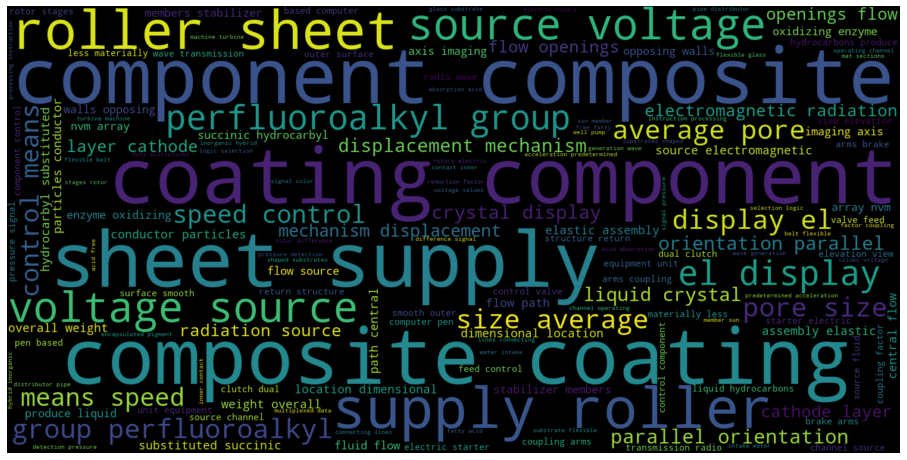

In [20]:
anchor_text = ' '.join(train['anchor'])

plt.subplots(figsize=(16,16))
wc = WordCloud(
    stopwords=STOPWORDS,
    background_color="black",
    contour_width=2,
    contour_color='yellow',
    width=1500,
    height=750,
    max_font_size=256,
    max_words=150,
    random_state=1
)
wc.generate(anchor_text)
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

###Target word clouding

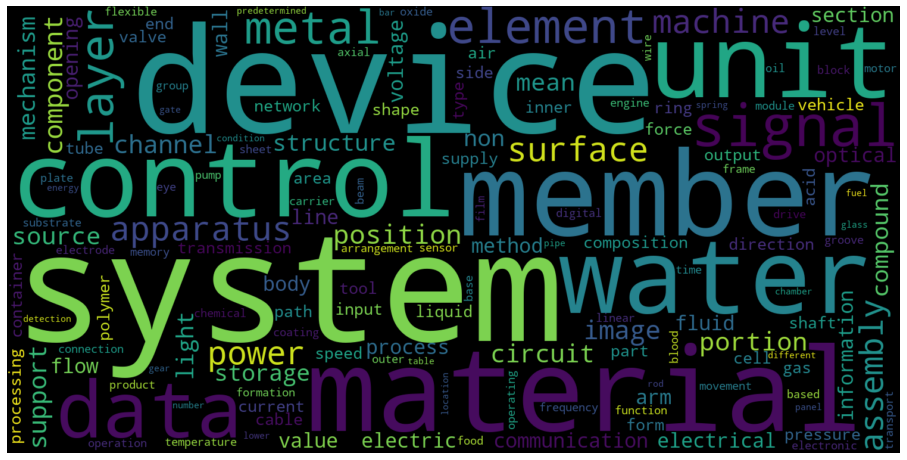

In [21]:
target_text = ' '.join(train['target'])

plt.subplots(figsize=(16,16))
wc = WordCloud(
    stopwords=STOPWORDS,
    background_color="black",
    contour_width=2,
    contour_color='yellow',
    width=1500,
    height=750,
    max_font_size=256,
    max_words=150,
    random_state=1
)
wc.generate(target_text)
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()